# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 74827634.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

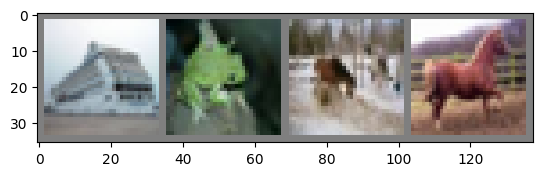

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=8)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(1)
        self.linear = nn.Linear(512, n_classes)

    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x1 = self.bn2(self.conv2(x1))
        x2 = self.conv3(x)
        x = self.pool(self.relu(x1+x2))
        out = self.linear(self.flatten(x))

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    criterion = nn.CrossEntropyLoss()
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        
        logits = model(data)
        loss = criterion(logits, target)
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    criterion = nn.CrossEntropyLoss()
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data) 
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        acc_log.append(acc.item()) 
        

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4564757842904252, train acc: 0.482514200851294
 val loss: 1.2050218663317092, val acc: 0.5746010638297873

Epoch 1
 train loss: 1.136856475957351, train acc: 0.603282515048109
 val loss: 1.1501905598538986, val acc: 0.6036125888215734

Epoch 2
 train loss: 1.030465818737281, train acc: 0.6400618634886454
 val loss: 1.067679685734688, val acc: 0.6324689718002968

Epoch 3
 train loss: 0.9822599381153937, train acc: 0.660265408769604
 val loss: 1.0801698626355922, val acc: 0.6326241135597229

Epoch 4
 train loss: 0.9444357711392739, train acc: 0.6733399713497057
 val loss: 0.9705608400892705, val acc: 0.6617686170212767

Epoch 5
 train loss: 0.9225633135661346, train acc: 0.6790937581925331
 val loss: 0.964585694607268, val acc: 0.6724955675449777

Epoch 6
 train loss: 0.8987408279282956, train acc: 0.6879447963381599
 val loss: 0.9819306974715375, val acc: 0.6666445037151905

Epoch 7
 train loss: 0.8798797565360827, train acc: 0.6942943653851148
 val loss: 0.969361

Посчитайте точность на тестовой выборке:

In [12]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.6968550955414012

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: >

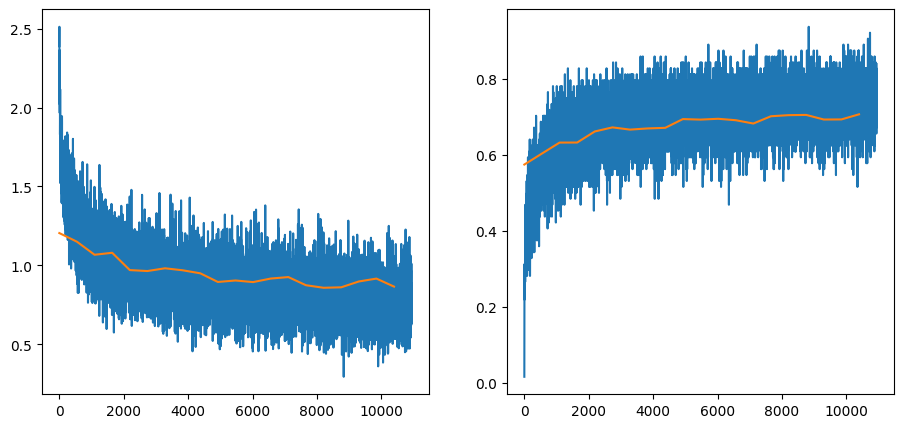

In [13]:
f, ax = plt.subplots(1, 2, figsize=(11, 5))

sns.lineplot(x=np.arange(len(train_loss_log)), y=train_loss_log, ax=ax[0])
sns.lineplot(x=np.arange(len(val_loss_log)) * len(train_loader), y=val_loss_log, ax=ax[0])

sns.lineplot(x=np.arange(len(train_acc_log)), y=train_acc_log, ax=ax[1])
sns.lineplot(x=np.arange(len(val_acc_log)) * len(train_loader), y=val_acc_log, ax=ax[1])

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [63]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5053540261179699, train acc: 0.4634246866489459
 val loss: 1.3382773338480198, val acc: 0.5371675531914893

Epoch 1
 train loss: 1.180622834392178, train acc: 0.5853070319243715
 val loss: 1.1474379795662901, val acc: 0.6004654255319148

Epoch 2
 train loss: 1.069022522765932, train acc: 0.6264445678189642
 val loss: 1.0392702325861505, val acc: 0.6409352837724889

Epoch 3
 train loss: 0.9976579758323307, train acc: 0.6536424327811986
 val loss: 1.0718039073842638, val acc: 0.6159131206096486

Epoch 4
 train loss: 0.9558813473860133, train acc: 0.6665619288109774
 val loss: 1.0758463197566093, val acc: 0.6304521276595745

Epoch 5
 train loss: 0.9212656722317231, train acc: 0.6811912380145281
 val loss: 0.9702361451818587, val acc: 0.6669326241980208

Epoch 6
 train loss: 0.898614149206953, train acc: 0.690172858495381
 val loss: 1.0449027038635093, val acc: 0.6459441489361702

Epoch 7
 train loss: 0.87743346978803, train acc: 0.6932701097981804
 val loss: 0.94850

Посчитайте точность на тестовой выборке:

In [64]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.71765525477707

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [65]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.7983506564902214, train acc: 0.3680954557559172
 val loss: 1.5979618569637866, val acc: 0.4379432624958931

Epoch 1
 train loss: 1.509754025739987, train acc: 0.467183011323486
 val loss: 1.4466865960587847, val acc: 0.4870124114320633

Epoch 2
 train loss: 1.396287166222358, train acc: 0.5083083050560472
 val loss: 1.3494488011015222, val acc: 0.5207225178150421

Epoch 3
 train loss: 1.32277590134462, train acc: 0.5349144686074754
 val loss: 1.2966998602481599, val acc: 0.5479831561129144

Epoch 4
 train loss: 1.2662467083721753, train acc: 0.5554077435673046
 val loss: 1.2395433053057245, val acc: 0.5661125886947551

Epoch 5
 train loss: 1.219238911729844, train acc: 0.5728772199785905
 val loss: 1.2678795986987175, val acc: 0.5515735816448293

Epoch 6
 train loss: 1.182512783590139, train acc: 0.5880737464868172
 val loss: 1.1745770226133632, val acc: 0.5832003546522019

Epoch 7
 train loss: 1.1462327184145369, train acc: 0.5994793027366973
 val loss: 1.150032

In [66]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.6607285031847133

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [77]:
# умножаем на gamma раз в step_size эпох

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.505157810024631, train acc: 0.4633226691042048
 val loss: 1.3140465005915216, val acc: 0.5356161348363186

Epoch 1
 train loss: 1.1991128269889455, train acc: 0.5771864391114202
 val loss: 1.1635562366627632, val acc: 0.5961214539852548

Epoch 2
 train loss: 1.0631159748848003, train acc: 0.6317249935331467
 val loss: 1.0644406810719915, val acc: 0.630474290949233

Epoch 3
 train loss: 0.96314237605937, train acc: 0.663974765013951
 val loss: 1.0003848486758293, val acc: 0.6626551420130629

Epoch 4
 train loss: 0.9357727499069199, train acc: 0.6741112236348977
 val loss: 0.9968439936637878, val acc: 0.6579787234042553

Epoch 5
 train loss: 0.9074688972786096, train acc: 0.6844639592894253
 val loss: 0.9582644657885775, val acc: 0.6677748228641267

Epoch 6
 train loss: 0.8591101942158268, train acc: 0.7027618177848063
 val loss: 0.9055646181106567, val acc: 0.6883643617021277

Epoch 7
 train loss: 0.8425847894530846, train acc: 0.7081320188816984
 val loss: 0.9555

In [78]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7084992038216561

In [79]:
# Устанавливает скорость обучения каждой группы параметров в соответствии с политикой циклической скорости обучения 

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4927665978070805, train acc: 0.4625228519195612
 val loss: 1.3212061166763305, val acc: 0.5218528369639782

Epoch 1
 train loss: 1.235736749180928, train acc: 0.5612227410023566
 val loss: 1.1783246649072525, val acc: 0.5897384752618505

Epoch 2
 train loss: 1.113197744982334, train acc: 0.6077345586781964
 val loss: 1.171886841540641, val acc: 0.5915780143534883

Epoch 3
 train loss: 1.0314386674429425, train acc: 0.6377889135855861
 val loss: 1.0938496734233614, val acc: 0.6154033688788718

Epoch 4
 train loss: 0.9883062030977043, train acc: 0.6526957104149422
 val loss: 1.02371708103951, val acc: 0.6369459220703612

Epoch 5
 train loss: 0.9470676559634793, train acc: 0.6701162183960352
 val loss: 0.9550492337409486, val acc: 0.6656914893617021

Epoch 6
 train loss: 0.9174511105748374, train acc: 0.6793712458183386
 val loss: 0.9302045844970865, val acc: 0.6731604610351806

Epoch 7
 train loss: 0.8932092203954456, train acc: 0.6894954623862202
 val loss: 0.9128

In [80]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7092953821656051

In [81]:
# применяем сразу несколько способов уменьшения lr последовательно

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1, scheduler2])
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.512243861472149, train acc: 0.4571159245545075
 val loss: 1.3267893207834123, val acc: 0.5216090425531915

Epoch 1
 train loss: 1.2119853966196887, train acc: 0.5748726822558443
 val loss: 1.322036208497717, val acc: 0.5414893617021277

Epoch 2
 train loss: 1.248624243073751, train acc: 0.5585376404539105
 val loss: 1.08417436493204, val acc: 0.620234929120287

Epoch 3
 train loss: 1.0479292835788274, train acc: 0.6358913881687185
 val loss: 1.0095647908271628, val acc: 0.6531693263256804

Epoch 4
 train loss: 0.9733606093108546, train acc: 0.6630443653851148
 val loss: 0.9710861741228306, val acc: 0.6650265957446808

Epoch 5
 train loss: 0.9219022496744745, train acc: 0.6824399321127199
 val loss: 0.9076069339792779, val acc: 0.6844858156873824

Epoch 6
 train loss: 0.8853652588410177, train acc: 0.6951105054161448
 val loss: 0.9236983989147429, val acc: 0.6824689718002969

Epoch 7
 train loss: 0.8478471731572962, train acc: 0.7097969444185985
 val loss: 0.89471

In [82]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7245222929936306

Your answers here: лучше всех показал себя ChainSchedular, показав 0.725 на тестовой выборке

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

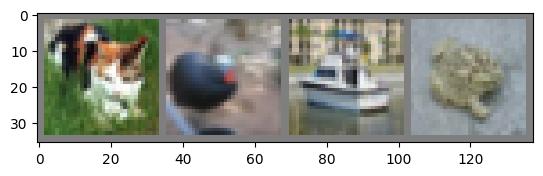

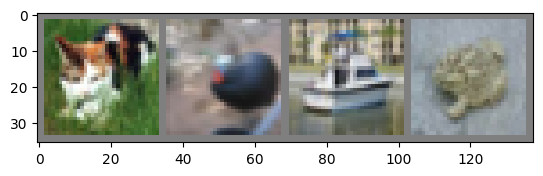

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [16]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.487360149240581, train acc: 0.46959470493048155
 val loss: 1.292814612134974, val acc: 0.5362367021276596

Epoch 1
 train loss: 1.1931380648063785, train acc: 0.5795981327184158
 val loss: 1.1408956946210658, val acc: 0.6028812057160317

Epoch 2
 train loss: 1.0646169592083263, train acc: 0.6278197636769938
 val loss: 1.0488460231334604, val acc: 0.6351950356300841

Epoch 3
 train loss: 1.0015799346528063, train acc: 0.6521407352722977
 val loss: 0.9697543177198856, val acc: 0.6635416667512123

Epoch 4
 train loss: 0.9622663446928509, train acc: 0.6659906307129799
 val loss: 0.9858753211954807, val acc: 0.6549645390916378

Epoch 5
 train loss: 0.9237498548392622, train acc: 0.6765596435100548
 val loss: 0.936327857920464, val acc: 0.6708111702127659

Epoch 6
 train loss: 0.907871601677464, train acc: 0.6873122878658706
 val loss: 0.954087791290689, val acc: 0.666533688027808

Epoch 7
 tra

Посчитайте точность на тестовой выборке:

In [17]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7274084394904459

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [22]:
# рандомно поворачивает картинки от минус 1 до 1
transform = transforms.Compose(
        [transforms.RandomRotation([-1.0, 1.0]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4956491742099225, train acc: 0.4661628363119401
 val loss: 1.3020962471657611, val acc: 0.5307845744680851

Epoch 1
 train loss: 1.1907026352568562, train acc: 0.5829524680073126
 val loss: 1.0770048778107826, val acc: 0.6211879433469569

Epoch 2
 train loss: 1.059326493979808, train acc: 0.6327492492290476
 val loss: 1.0619476602432576, val acc: 0.6365691489361702

Epoch 3
 train loss: 0.9873829349957175, train acc: 0.6578088274167704
 val loss: 1.0029349859724654, val acc: 0.6522606382978723

Epoch 4
 train loss: 0.9422155091270015, train acc: 0.6736827501431244
 val loss: 1.0017414820955155, val acc: 0.6545212765957447

Epoch 5
 train loss: 0.9084107867106659, train acc: 0.6848271416135854
 val loss: 0.9505370221239455, val acc: 0.6687943263256804

Epoch 6
 train loss: 0.8858997062311748, train acc: 0.6911644686074754
 val loss: 0.9839184190364594, val acc: 0.6546764184819891

Epoch 7


In [23]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7237261146496815

Лучшего качества добиться не удалось

In [25]:
#блюрит картиники с помощью гауссовского размытия
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5505634158359367, train acc: 0.45002774880616714
 val loss: 1.353230123316988, val acc: 0.5121675531914893

Epoch 1
 train loss: 1.2807962406270028, train acc: 0.547385087505773
 val loss: 1.1720271331198673, val acc: 0.5862145390916378

Epoch 2
 train loss: 1.1749543194579033, train acc: 0.5884369287020109
 val loss: 1.143941687015777, val acc: 0.6049202127659574

Epoch 3
 train loss: 1.1191320144716086, train acc: 0.6090811896367744
 val loss: 1.0899466854460695, val acc: 0.6230718085106383

Epoch 4
 train loss: 1.0761756817427153, train acc: 0.6243838143740973
 val loss: 1.102574382690673, val acc: 0.6167331561129143

Epoch 5
 train loss: 1.0473250823003502, train acc: 0.6321983546617916
 val loss: 1.0605507018718314, val acc: 0.6285460994598714

Epoch 6
 train loss: 1.0272768690119713, train acc: 0.6402373335697097
 val loss: 1.0447817553865149, val acc: 0.632313829787234

Epoch 7
 tr

In [26]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.683718152866242

In [27]:
#изменяет цветовые значения пикселей
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.5, hue=0.3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6820381770840074, train acc: 0.40054110084852745
 val loss: 1.430165042268469, val acc: 0.49432624121929736

Epoch 1
 train loss: 1.3371245044894802, train acc: 0.5334250131516396
 val loss: 1.250533562264544, val acc: 0.5709441489361702

Epoch 2
 train loss: 1.1992078510673216, train acc: 0.5852213372260169
 val loss: 1.1829635199080122, val acc: 0.5927748228641266

Epoch 3
 train loss: 1.142030947496076, train acc: 0.6072734396026165
 val loss: 1.1855318071994376, val acc: 0.590469858240574

Epoch 4
 train loss: 1.0944772646021799, train acc: 0.6232044921278735
 val loss: 1.0938634037971497, val acc: 0.6205452127659574

Epoch 5
 train loss: 1.0687383720600192, train acc: 0.6300192609347635
 val loss: 1.077426992832346, val acc: 0.6302748228641266

Epoch 6
 train loss: 1.0407661913299908, train acc: 0.6430570972467036
 val loss: 1.0311662077903747, val acc: 0.6419326241980208

Epoch 7
 t

In [28]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7009355095541401

In [29]:
#меняет угол, с которого мы смотрим на картинку
transform = transforms.Compose(
        [transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.8299005439120193, train acc: 0.33319322936495654
 val loss: 1.6603026242966348, val acc: 0.38218085106382976

Epoch 1
 train loss: 1.6114532010428866, train acc: 0.4117956712324397
 val loss: 1.563114633458726, val acc: 0.4338209220703612

Epoch 2
 train loss: 1.5257280382857243, train acc: 0.4449758422875971
 val loss: 1.4294149058930417, val acc: 0.4867464539852548

Epoch 3
 train loss: 1.4684182614687373, train acc: 0.4685092387513225
 val loss: 1.4138524304045008, val acc: 0.4933067376309253

Epoch 4
 train loss: 1.4086429495262272, train acc: 0.49366267306059325
 val loss: 1.4064316592317947, val acc: 0.49394946808510637

Epoch 5
 train loss: 1.3648173097500635, train acc: 0.5111974405850092
 val loss: 1.3471992583985024, val acc: 0.5186170212765957

Epoch 6
 train loss: 1.332889242952441, train acc: 0.5244148276623686
 val loss: 1.3439910815117206, val acc: 0.5148936170212766

Epoch

In [30]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.6089769108280255

In [31]:
#попробуем два лучших transform для модели
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomRotation([-1.0, 1.0]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4846887207118422, train acc: 0.47291231395121686
 val loss: 1.2619321150982634, val acc: 0.5454787234042553

Epoch 1
 train loss: 1.1673781501309746, train acc: 0.5901875490462323
 val loss: 1.075479018688202, val acc: 0.622872340425532

Epoch 2
 train loss: 1.0513160948997442, train acc: 0.6331858840895309
 val loss: 1.0024872975146517, val acc: 0.6557845744680851

Epoch 3
 train loss: 0.9951209006405399, train acc: 0.6534220749542962
 val loss: 0.9557270564931504, val acc: 0.6675975178150421

Epoch 4
 train loss: 0.9535503945359364, train acc: 0.6698591343009712
 val loss: 0.9870491344878014, val acc: 0.6547650710065314

Epoch 5
 train loss: 0.9260328536277715, train acc: 0.6807219574612717
 val loss: 0.9560939991727788, val acc: 0.668594858240574

Epoch 6
 train loss: 0.9107697978751969, train acc: 0.6833621703728462
 val loss: 0.9403973866016306, val acc: 0.673936170212766

Epoch 7
 t

In [32]:
loss, acc = test(net, test_loader)
np.mean(acc)

0.7201433121019108

Лучшего качества добиться не удалось, самым полезным оказалось отражать кратинки по горизантали

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>